## Aims to supplement existing IG scraper

https://apify.com/apify/instagram-comment-scraper

takes Post URL and scrapes top 15 comments per post

total 36 accs * 50 posts scraped per page

In [ ]:
#pip install apify_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 73.5 MB/s eta 0:00:00


In [21]:
from google.colab import drive
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
from collections import Counter
import os, time, json, re, requests
from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer

os.environ['APIFY_TOKEN'] = 'apify_api_C9w5PGfVuyN8FjkgoIwM0cVw7Ynh3118Nvtg'

from apify_client import ApifyClient
client = ApifyClient(os.environ['APIFY_TOKEN'])

In [22]:
# Uncomment to mount Google Drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/FYP/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/FYP


In [ ]:
df = pd.read_excel("cat_data_with_comments.xlsx")

#uncomment to convert
# # Save as CSV
# df.to_csv("tiktok_general_data.csv", index=False)

In [ ]:
# !pip -q install apify-client tqdm
# !pip -q install tqdm

In [ ]:
distinct_urls = df['Post URL'].dropna().unique()
urls_list = distinct_urls.tolist()
print(len(urls_list))

1765


In [ ]:
first_200_urls = urls_list[:200]
second_200_urls = urls_list[200:400]
third_200_urls = urls_list[400:600]
fourth_200_urls = urls_list[600:800]
fifth_200_urls = urls_list[800:1000]

# Prepare the Actor input
run_input = {
    "directUrls": fifth_200_urls,
    "resultsLimit": 10,
}

# Run the Actor and wait for it to finish
run = client.actor("apify/instagram-comment-scraper").call(run_input=run_input)

run_id = run["id"]
run_status = run["status"]
# Show progress bar
with tqdm(total=100, desc="Actor run progress", unit="%") as pbar:
    last_pct = 0
    while run_status not in ["SUCCEEDED", "FAILED", "ABORTED", "TIMED-OUT"]:
        # Refresh run info
        run = client.run(run_id).get()
        run_status = run["status"]

        pct = run.get("stats", {}).get("progress", run.get("progressPct", 0))
        pct = int(pct) if pct is not None else 0

        # Update bar if new progress seen
        if pct > last_pct:
            pbar.update(pct - last_pct)
            last_pct = pct

        time.sleep(5)
    if run_status == "SUCCEEDED" and last_pct < 100:
        pbar.update(100 - last_pct)

print("Run finished with status:", run_status)


[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> Status: RUNNING, Message: 
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:03.392Z ACTOR: Pulling Docker image of build nYltKL6mpqXf7bOl8 from registry.
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:03.400Z ACTOR: Creating Docker container.
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:03.777Z ACTOR: Starting Docker container.
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:05.453Z INFO  System info {"apifyVersion":"3.4.4","apifyClientVersion":"2.12.2","crawleeVersion":"3.13.2","osType":"Linux","nodeVersion":"v20.19.5"}
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:05.619Z INFO  Results Limit [object Object], ACTOR_MAX_PAID_DATASET_ITEMS 2173
[apify.instagram-comment-scraper runId:pldfKnUoVcqq1s7us] -> 2025-09-15T07:33:05.620Z INFO  pushDataMaxAware 2173
[apify.instagram-c

Actor run progress:   0%|          | 0/100 [00:00<?, ?%/s]

Run finished with status: SUCCEEDED


In [ ]:
items = client.dataset(run["defaultDatasetId"]).list_items().items
results_df = pd.DataFrame(items)
# print(results_df.head())

In [ ]:
if 'postUrl' in results_df.columns:
    results_df.rename(columns={'postUrl': 'Post URL'}, inplace=True)

# Merge results with the original DataFrame on 'Post URL'
merged_df = df.merge(results_df, on='Post URL', how='left')

# Save the combined DataFrame to Excel
merged_df.to_excel("cat_data_with_comments.xlsx", index=False)

print("Merged data saved to cat_data_with_comments.xlsx")

Merged data saved to cat_data_with_comments.xlsx


In [ ]:
from collections import defaultdict

df = pd.read_excel("cat_data_with_comments.xlsx")

# Step 1: Group columns by their base name (strip _x and _y suffixes)
groups = defaultdict(list)
for col in df.columns:
    base = col
    if base.endswith(('_x', '_y')):
        base = base.rsplit('_', 1)[0]
    groups[base].append(col)

# Step 2: Merge columns within each group into a single column
merged_df = pd.DataFrame()
for base, cols in groups.items():
    if len(cols) == 1:
        # Only one column with this base name
        merged_df[base] = df[cols[0]]
    else:
        # Combine multiple columns (take first non-null value row-wise)
        merged_df[base] = df[cols].bfill(axis=1).iloc[:, 0]

# print(merged_df.head())

In [ ]:
# Step 3: Save the cleaned file
merged_df.to_excel("cat_data_with_comments.xlsx", index=False)

## Threshold decision methods

1. Median
2. Quantile (e.g. 75th percentile)
3. Statistical clustering
4. Domain rule (e.g. 1000 likes)

**Goal:**
Divide the reels into two groups for each metric so you can test different hypotheses:

* Likes: posts below the threshold vs. posts at or above the threshold
* Comments: posts below the threshold vs. posts at or above the threshold
* Views: posts below the threshold vs. posts at or above the threshold

Example hypothesis: Reels featuring black cats receive more likes.

Add new columns to existing dataset
"likes_group", "comments_group", "views_group" where 1 = above threshold and 0 = below threshold


In [23]:
df = pd.read_excel("cat_data_with_comments.xlsx")

for col in ["Likes", "Comments", "Views"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# # Median
# thresholds = {
#     "Likes": df["Likes"].median(),
#     "Comments": df["Comments"].median(),
#     "Views": df["Views"].median()
# }

# Quantile (e.g. 75th percentile)
thresholds = {
    "Likes": df["Likes"].quantile(0.75),
    "Comments": df["Comments"].quantile(0.75),
    "Views": df["Views"].quantile(0.75)
}

# # Statistical clustering
# metrics = ["Likes", "Comments", "Views"]
# thresholds = {}

# for col in metrics:
#     s = pd.to_numeric(df[col], errors="coerce")
#     x = s.to_numpy(dtype=float)
#     x = x[np.isfinite(x)]
#     x = x[x >= 0]
#     if x.size < 2 or np.unique(x).size < 2:
#         thresholds[col] = float(np.nan if x.size == 0 else np.median(x))
#         continue

#     hi = np.quantile(x, 0.999)
#     x = np.clip(x, None, hi)

#     try:
#         X = np.log1p(x).reshape(-1, 1)
#         if not np.isfinite(X).all():
#             raise ValueError("Non-finite after log transform")

#         km = KMeans(n_clusters=2, n_init=10, random_state=42)
#         km.fit(X)

#         centers = np.sort(km.cluster_centers_.ravel())
#         boundary_log = (centers[0] + centers[1]) / 2.0
#         thr = float(np.expm1(boundary_log))
#     except Exception:
#         pt = PowerTransformer(method="yeo-johnson", standardize=True)
#         X = pt.fit_transform(x.reshape(-1, 1))
#         km = KMeans(n_clusters=2, n_init=10, random_state=42)
#         km.fit(X)
#         centers = np.sort(km.cluster_centers_.ravel())
#         boundary_t = (centers[0] + centers[1]) / 2.0
#         thr = float(pt.inverse_transform([[boundary_t]])[0, 0])

#     thresholds[col] = thr

# # Domain rule (e.g. 1000 likes)
# thresholds = {
#     "Likes": 5000,
#     "Comments": 100,
#     "Views": 500000
# }

print(thresholds)

df["likes_group"] = df["Likes"].apply(lambda x: 1 if x >= thresholds["Likes"] else 0)
df["comments_group"] = df["Comments"].apply(lambda x: 1 if x >= thresholds["Comments"] else 0)
df["views_group"] = df["Views"].apply(lambda x: 1 if x >= thresholds["Views"] else 0)

df.to_excel("cat_data_with_comments.xlsx", index=False)
df.to_json("cat_data_with_comments.json", orient="records", indent=4)

{'Likes': np.float64(42318.0), 'Comments': np.float64(300.0), 'Views': np.float64(710720.0)}


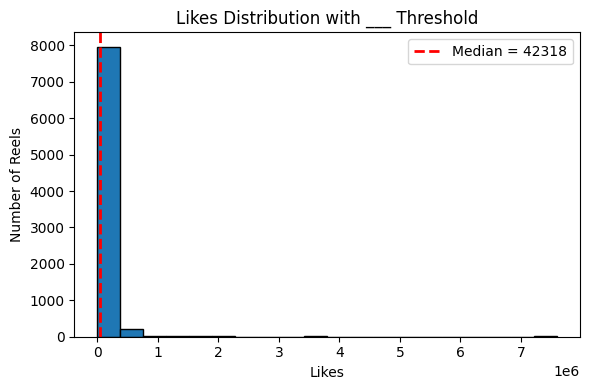

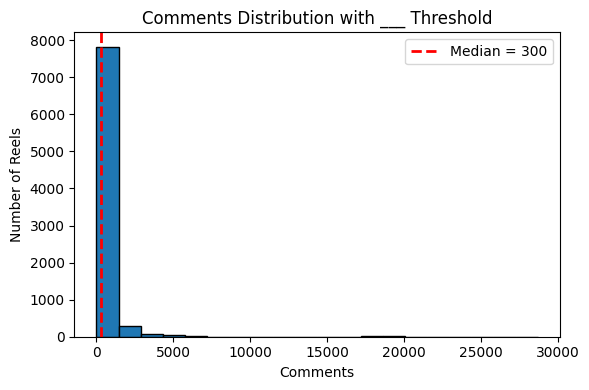

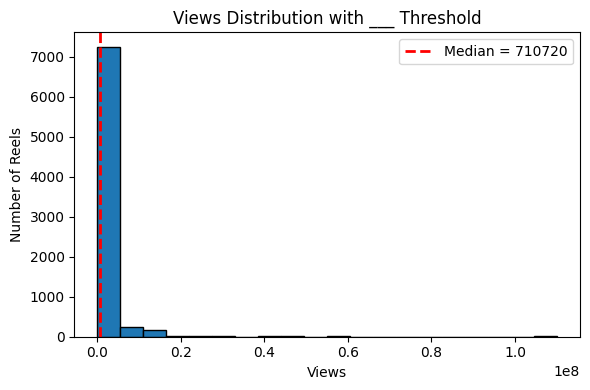

In [ ]:
#summary table
summary = []
for metric in ["Likes", "Comments", "Views"]:
    below = (df[metric] < thresholds[metric]).sum()
    above = (df[metric] >= thresholds[metric]).sum()
    summary.append({
        "Metric": metric,
        "Threshold": thresholds[metric],
        "Below": below,
        "Above": above
    })

summary_df = pd.DataFrame(summary)
summary_df

# Plot histograms with threshold lines
for metric in ["Likes", "Comments", "Views"]:
    plt.figure(figsize=(6,4))
    plt.hist(df[metric], bins=20, edgecolor='black')
    plt.axvline(thresholds[metric], color='red', linestyle='--', linewidth=2,
                label=f"Median = {thresholds[metric]:.0f}")
    plt.title(f"{metric} Distribution with ___ Threshold")
    plt.xlabel(metric)
    plt.ylabel("Number of Reels")
    plt.legend()
    plt.tight_layout()
    plt.show()